In [255]:
import torch
import chess
import pandas as pd
import numpy as np
from torch import nn
from random import shuffle
from torch.utils.data import DataLoader, Dataset

In [256]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [266]:
data = pd.read_csv('chessData.csv')[:100000]

In [269]:
class Data(Dataset):
    def __init__(self, data, test=False):
        l, r = 0, int(len(data) * 0.9)
        if test: l, r = r, len(data)
        fen = []
        self.score = []
        piece = {' ': 0,
                 'r': 1, 'n': 2, 'b': 3, 'q': 4, 'k': 5, 'p': 6,
                 'R': 7, 'N': 8, 'B': 9, 'Q': 10, 'K': 11, 'P': 12}
        for fn, sc in zip(data[l:r]['FEN'], data[l:r]['Evaluation']):
            fn, sd = fn.split()[:2]
            mul = 1
            if sd == 'w':
                mul = -1
                fn = chess.Board(fn).mirror().fen().split()[0]
            fn = [''.join(int(j) * ' ' if j.isdigit() else j for j in i) for i in fn.split('/')]
            fn = [[piece[j] for j in i] for i in fn]
            fen.append(fn)
            sgn = 1 if '+' in sc else -1
            self.score.append((15000 * sgn if sc.startswith('#') else int(sc)) * mul)
        fen = np.array(fen)
        self.board = np.zeros((len(fen), 12, 8, 8))
        for i in range(len(fen)):
            for y in range(8):
                for x in range(8):
                    piece = fen[i, y, x]
                    if piece == 0: continue
                    self.board[i, piece - 1, y, x] = 1
        self.board = torch.tensor(self.board).float()
        self.score = torch.tensor(self.score)[:, None].float()

    def __len__(self):
        return len(self.score)

    def __getitem__(self, item):
        return self.board[item].to(device), self.score[item].to(device)

In [270]:
train = DataLoader(Data(data, test=False), 64, True)
test = DataLoader(Data(data, test=True), 64, True)

In [271]:
model = nn.Sequential(
    nn.Conv2d(12, 8, 15, 1, 7),
    nn.GELU(),
    *(
        nn.Sequential(
            nn.Conv2d(8, 8, 15, 1, 7),
            nn.GELU(),
            nn.Dropout(0.2),
        )
        for _ in range(5)
    ),
    nn.Conv2d(8, 256, 8),
    nn.GELU(),
    nn.Flatten(),
    nn.Linear(256, 64),
    nn.GELU(),
    nn.Linear(64, 16),
    nn.GELU(),
    nn.Linear(16, 1)
).to(device)

loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters())

train_loss = []
test_loss = []
best = float('inf')

In [276]:
for epoch in range(25):
    print(f'Epoch {epoch}...')
    model.train()
    Loss = []
    for board, score in train:
        sc = model(board)

        loss = loss_fn(sc, score)

        Loss.append(loss.item())

        optim.zero_grad()
        loss.backward()
        optim.step()
    loss = sum(Loss) / len(Loss)
    train_loss.append(loss)
    print(f'Train loss: {loss}')
    model.eval()
    Loss = []
    for board, score in test:
        sc = model(board)

        loss = loss_fn(sc, score)

        Loss.append(loss.item())
    loss = sum(Loss) / len(Loss)
    test_loss.append(loss)
    if loss < best:
        best = loss
        torch.save(model, 'best.pt')
    print(f'Test loss:{loss}')

Epoch 0...
Train loss: 168213.7352981188
Test loss:1776974.0796924762
Epoch 1...
Train loss: 157701.89149259284
Test loss:1792767.6286325636
Epoch 2...
Train loss: 156782.85661883108
Test loss:1749166.0377935907
Epoch 3...
Train loss: 138013.54212475568
Test loss:1747938.068875647
Epoch 4...
Train loss: 145723.49020105944
Test loss:1821694.966311704
Epoch 5...
Train loss: 158314.10916053105
Test loss:1749957.451171875
Epoch 6...
Train loss: 140161.0382018479
Test loss:1794273.114326234
Epoch 7...
Train loss: 153857.05887068564
Test loss:1795037.7703647492
Epoch 8...
Train loss: 141185.94459135682
Test loss:1807334.1632165606
Epoch 9...
Train loss: 148516.0645877754
Test loss:1782838.169872114
Epoch 10...
Train loss: 136695.09382148966
Test loss:1788670.8343949046
Epoch 11...
Train loss: 145155.00475232652
Test loss:1752397.8470839967
Epoch 12...
Train loss: 129153.24912199605
Test loss:1780119.6836932723
Epoch 13...
Train loss: 137891.333293077
Test loss:1771367.3450686703
Epoch 14...


KeyboardInterrupt: 

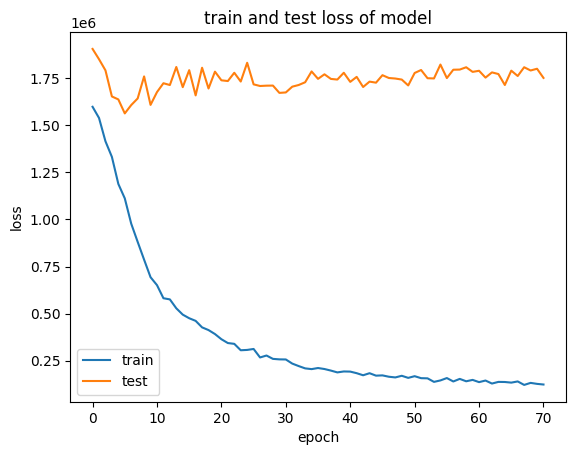

In [277]:
from matplotlib import pyplot as plt

plt.title('train and test loss of model')
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()